In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Reload library
from importlib import reload

# Local application imports
import smile.smile; reload(smile.smile)
from smile.smile import PopulationList
from smile.smile import RegressionResultList, RegressionResult
from smile.smile import TraditionalMethodology, SmileMethodology, MixedMethodology
import smile.example_populations; reload(smile.example_populations)
import smile.helper; reload(smile.helper)
import smile.global_params; reload(smile.global_params);

In [3]:
# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)

# Population generation

In [4]:
pops_noerror, pops_mulerror, pops_adderror = smile.example_populations.get_useful_poplists(100)
    
pops_noerror.generate()
pops_mulerror.generate()
pops_adderror.generate()

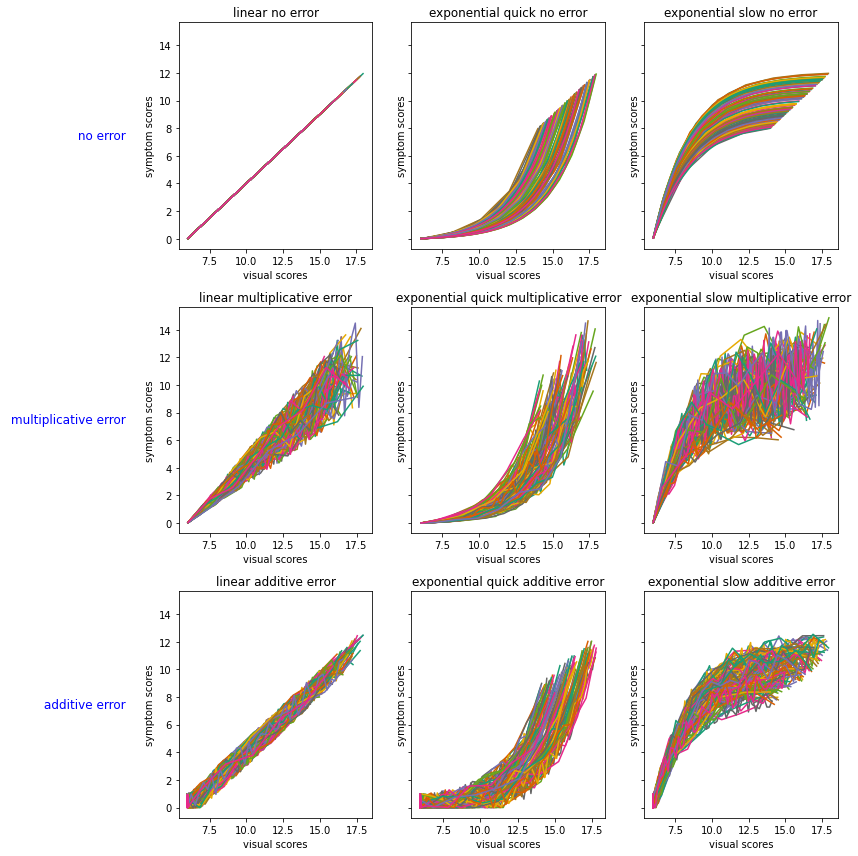

In [5]:
ncols = len(pops_noerror)
nrows = len([pops_noerror, pops_mulerror, pops_adderror])

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*3, sharey=True)
npersons=None
ndays=None

pops_noerror.plot(axes[0, :], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
pops_mulerror.plot(axes[1, :], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
pops_adderror.plot(axes[2, :], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

# Study

## Comparing traditional studies

In [6]:
pops = pops_mulerror

In [7]:
methodologies = [TraditionalMethodology('trad short', [8, 15, 29]), TraditionalMethodology('trad long', [8, 29, 90])]

meth_pops = []
for methodology in methodologies:
    meth_pops.append(methodology.sample(pops))

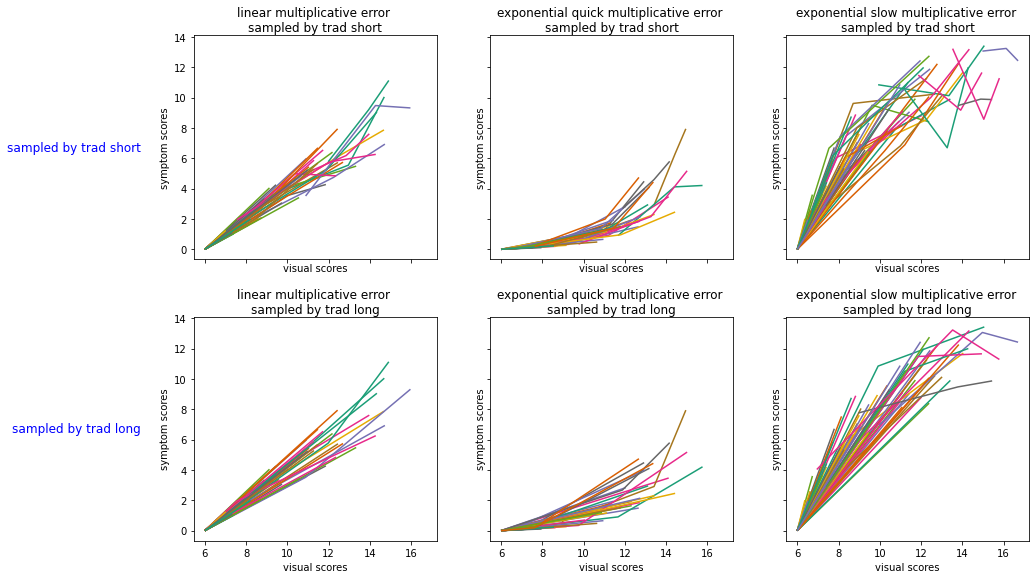

In [8]:
ncols = len(meth_pops[0])
nrows = len(meth_pops)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops[row].plot(axes[row, :], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
fig.subplots_adjust(left=0.005, top=0.95)
plt.show()

## Comparing traditional to smile studies

In [9]:
pops = pops_adderror

In [10]:
methodologies2 = [TraditionalMethodology('trad short', [8, 15, 29, 90]), 
                  SmileMethodology('smile', index_day=8, milestone_ratios=[0.7, 0.4, 0.1], delay=0),
                  SmileMethodology('delayed', index_day=8, milestone_ratios=[0.7, 0.4, 0.1], delay=lambda shape: np.random.choice([10, 20], shape))]
methodologies2.append(MixedMethodology.from_methodologies(methodologies2[0], methodologies2[1]))

meth_pops2 = []
for methodology in methodologies2:
    meth_pops2.append(methodology.sample(pops))

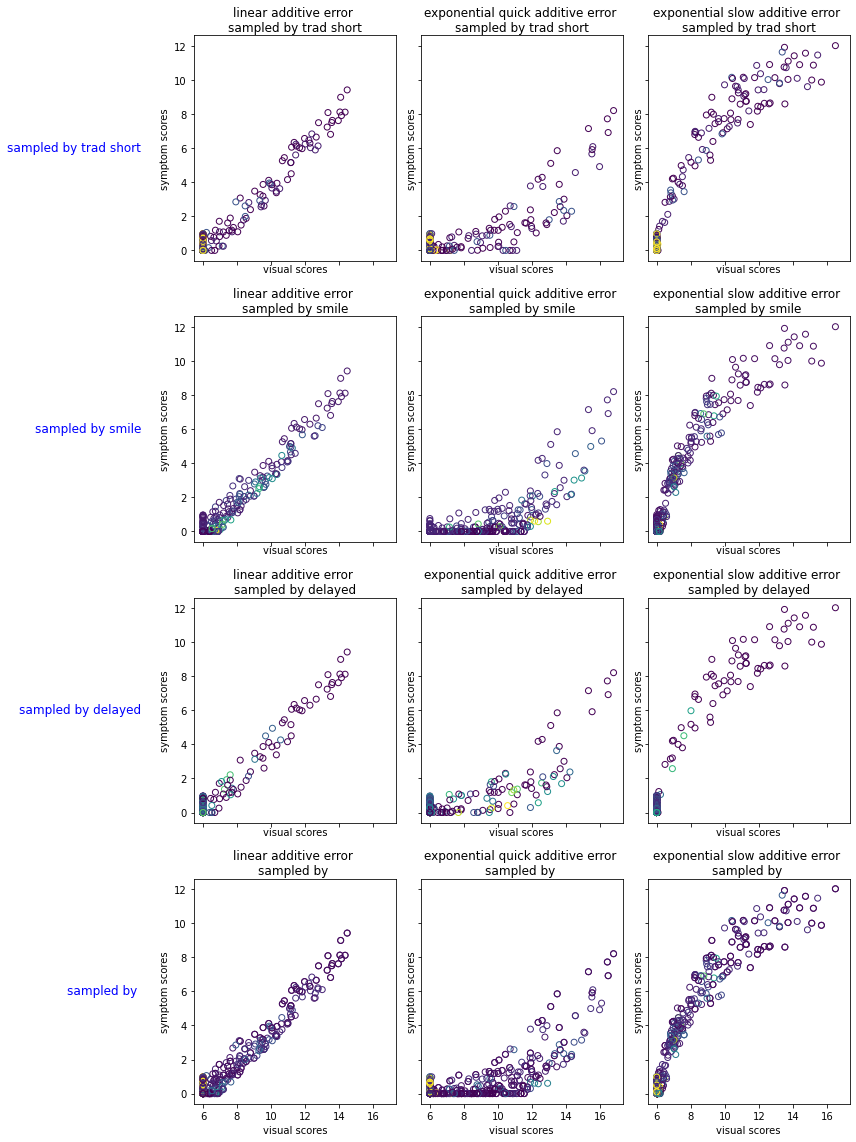

In [11]:
ncols = len(meth_pops2[0])
nrows = len(meth_pops2)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*3, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops2[row].plot(axes[row, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

## Mixed Effects Regression
(Without sampling nor filtering)

In [12]:
npersons = 10
npops = 10
#See run times in later markdown cell

pops_noerror, pops_mulerror, pops_adderror = smile.example_populations.get_useful_poplists(npersons)

list_of_poplists = [PopulationList.full(npops, pops_noerror[0]), PopulationList.full(npops, pops_mulerror[0]), PopulationList.full(npops, pops_adderror[0])]

for poplist in list_of_poplists:
    poplist.generate()

In [13]:
from datetime import datetime
print(datetime.now().strftime("%H:%M"))

18:27


In [14]:

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #likev = mdf.profile_re(0, 're', dist_low=0.1, dist_high=0.1)
    #https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html

    list_of_results = []
    for poplist in list_of_poplists:
        start = datetime.now()
        
        list_of_results.append(poplist.regress_mixed())
        
        end = datetime.now()
        delta = int((end-start).total_seconds())
        print(f"Took {delta//60} minutes {delta%60} seconds to run {poplist.title} for npersons={npersons}, npops={npops}")

Took 0 minutes 16 seconds to run list of linear no error for npersons=10, npops=10
Took 0 minutes 17 seconds to run list of linear multiplicative error for npersons=10, npops=10
Took 0 minutes 10 seconds to run list of linear additive error for npersons=10, npops=10


**Mixed regression run times:**

|            | npops |   10   |   30   |   100  |
|------------|-------|--------|--------|--------|
|**npersons**|       |        |        |        |
|**10**      |       |**20 s**|**20 s**|**15 s**|
|**30**      |       |**2 m** | **2 m**| **2 m**|
|**100**     |       |**25 m**|**25 m**|**25 m**|

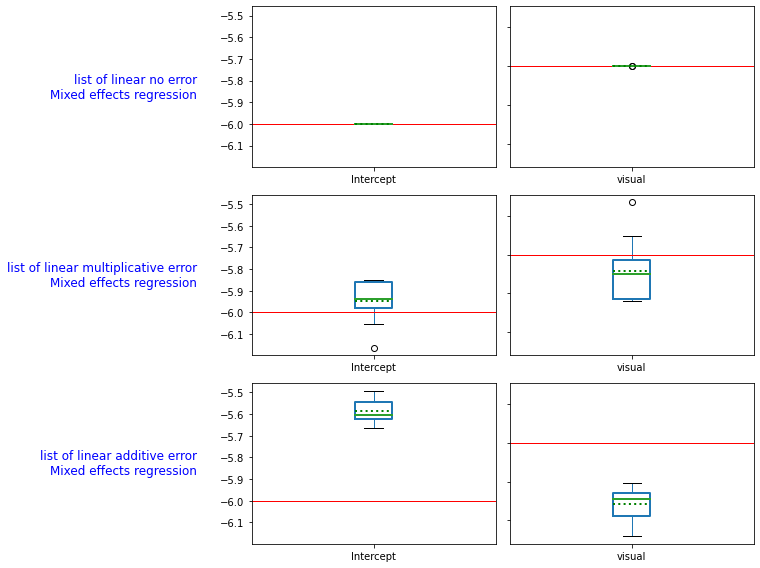

In [15]:
ncols = 2 #number of parameters, TODO
nrows = len(list_of_results)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(0.5*nrows/ncols)*2, sharey='col', squeeze=False)

for row in range(nrows):
    slope_truth = 1
    intercept_truth = slope_truth * -smile.global_params.VMIN
    list_of_results[row].plot_box(axes[row], ground_truths=[intercept_truth, slope_truth])
        
plt.tight_layout()
plt.show()
#dotted green line is the mean, solid green line is the median

In [16]:
import pandas as pd

def format_fn(val):
    if abs(val) < 1e-4: return f'{val:<.2e}'
    elif abs(val) < 1e-3: return f'{val:.4f}'
    elif abs(val) < 1e-2: return f'{val:.3f}'
    else: return f'{val:.2f}'
    
def format_percentage_fn(val):
    return format_fn(val)+" %"

In [17]:
list_of_biases = [results.get_percentage_biases([intercept_truth, slope_truth]) for results in list_of_results]
df_of_biases = pd.concat(list_of_biases, axis=1).transpose()
df_of_biases.index = [poplist.title for poplist in list_of_poplists]
df_of_biases_formatted = df_of_biases.style.format({key:format_percentage_fn for key in df_of_biases.columns})
df_of_biases_formatted

Percentage Biases,Intercept (%),visual (%)
list of linear no error,-3.85e-12 %,1.15e-10 %
list of linear multiplicative error,-0.87 %,-0.84 %
list of linear additive error,-6.90 %,-3.17 %


In [18]:
list_of_mses = [results.get_mses([intercept_truth, slope_truth]) for results in list_of_results]
df_of_mses = pd.concat(list_of_mses, axis=1).transpose()
df_of_mses.index = [poplist.title for poplist in list_of_poplists]
df_of_mses_formatted = df_of_mses.style.format({key:format_fn for key in df_of_mses.columns})
df_of_mses_formatted

from IPython.core.display import display, HTML

display(HTML(df_of_mses_formatted.render()))

MSEs,Intercept,visual
list of linear no error,3.40e-25,8.37e-24
list of linear multiplicative error,0.01,0.0003
list of linear additive error,0.17,0.001


In [19]:
list_of_sample_stdevs = [results.get_sample_stdevs() for results in list_of_results]
df_of_sample_stdevs = pd.concat(list_of_sample_stdevs, axis=1).transpose()
df_of_sample_stdevs.index = [poplist.title for poplist in list_of_poplists]
df_of_sample_stdevs_formatted = df_of_sample_stdevs.style.format({key:format_fn for key in df_of_sample_stdevs.columns})

list_of_stdevs = [results.get_stdevs([intercept_truth, slope_truth]) for results in list_of_results]
df_of_stdevs = pd.concat(list_of_stdevs, axis=1).transpose()
df_of_stdevs.index = [poplist.title for poplist in list_of_poplists]
df_of_stdevs_formatted = df_of_stdevs.style.format({key:format_fn for key in df_of_stdevs.columns})

smile.helper.display_collocated([df.render() for df in [df_of_sample_stdevs_formatted, df_of_stdevs_formatted]])

Sample Std Devs,Intercept,visual
list of linear no error,5.64e-13,2.80e-12
list of linear multiplicative error,0.10,0.02
list of linear additive error,0.05,0.009
Std Devs,Intercept,visual
list of linear no error,5.35e-13,2.65e-12
list of linear multiplicative error,0.10,0.02
list of linear additive error,0.05,0.008


				hmm, what does this mean? Is it okay?
				also, why are the names the same?


In [20]:
list_of_sample_stderrs = [results.get_sample_stderrs() for results in list_of_results]
df_of_sample_stderrs = pd.concat(list_of_sample_stderrs, axis=1).transpose()
df_of_sample_stderrs.index = [poplist.title for poplist in list_of_poplists]
df_of_sample_stderrs_formatted = df_of_sample_stderrs.style.format({key:format_fn for key in df_of_sample_stderrs.columns})

list_of_stderrs = [results.get_stderrs([intercept_truth, slope_truth]) for results in list_of_results]
df_of_stderrs = pd.concat(list_of_stderrs, axis=1).transpose()
df_of_stderrs.index = [poplist.title for poplist in list_of_poplists]
df_of_stderrs_formatted = df_of_stderrs.style.format({key:format_fn for key in df_of_stderrs.columns})

smile.helper.display_collocated([df.render() for df in [df_of_sample_stderrs_formatted, df_of_stderrs_formatted]])

Sample Std Errors,Intercept,visual
list of linear no error,1.78e-13,8.85e-13
list of linear multiplicative error,0.03,0.005
list of linear additive error,0.02,0.003
Std Errors,Intercept,visual
list of linear no error,1.69e-13,8.39e-13
list of linear multiplicative error,0.03,0.005
list of linear additive error,0.02,0.003


				hmm, what does this mean? Is it okay?
				also, why are the names the same?
